In [103]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from IPython.display import clear_output

In [104]:
def read_kImage(path):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(path)
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    return ct_scan

In [105]:
def extract_voxel_data(series_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( series_path )
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image_3d = sitk.GetArrayFromImage(image)
    return image_3d

In [106]:
def normalize_image(image_3D):
    z,y,x = image_3D.shape
    new_image_3D = np.empty(shape = (z,y,x) )
    target_min = -1
    target_max = 1
    for i in range (z):
        max_value = np.max (image_3D[i])
        min_value = np.min (image_3D[i])
        new_image_3D[i] = (image_3D[i] - min_value)*(float(target_max - target_min)/(max_value - min_value)) + target_min
    return new_image_3D

In [107]:
def subvoxel (img_3d,ijk, window):
    ijk = ijk.split()
    x = int(ijk[0])
    y = int(ijk[1])
    z = int(ijk[2])
    if (z < 0):
        z = z*(-1)
    new_img3d = np.empty(shape = (3,img_3d.shape[1], img_3d.shape[2]))
    max_bandwith = img_3d.shape[0] - 1
    if ( z == max_bandwith ):
        new_img3d[0,:,:] = img_3d[z-1,:,:] #n-1
        new_img3d[1,:,:] = img_3d[z,:,:] #n
        new_img3d[2,:,:] = img_3d[z,:,:] #n
    else:
        if (z == 0):
            new_img3d[0,:,:] = img_3d[z,:,:] #0
            new_img3d[1,:,:] = img_3d[z,:,:] #0
            new_img3d[2,:,:] = img_3d[z+1,:,:] #1
        else:
            new_img3d[0,:,:] = img_3d[z-1,:,:] #n-1
            new_img3d[1,:,:] = img_3d[z,:,:] #n
            new_img3d[2,:,:] = img_3d[z+1,:,:] #n+1
    window = window//2
    new_img3d = new_img3d[:, y-window : y+window, x-window : x+window]
    return new_img3d

In [108]:
def generate_training_dataframes():
    basedir = "../2/train/ProstateX2-DataInfo-Train"
    findingsfile = "{}/{}".format(basedir,"ProstateX-2-Findings-Train.csv")
    imagesfile = "{}/{}".format(basedir,"ProstateX-2-Images-Train.csv")
    kimagesfile = "{}/{}".format(basedir,"ProstateX-Images-KTrans-Train.csv")
    #Generamos las 3 tablas básicas a partir de los archivos.cvs
    findings_table = pd.read_csv(findingsfile)
    images_table = pd.read_csv(imagesfile)
    kimages_table = pd.read_csv(kimagesfile)
    #Operación de inner join entre tablas.
    join_kimages_table = pd.merge(left=findings_table, right= kimages_table, how ="inner", on=["ProxID","fid"])
    join_images_table =  pd.merge(left=findings_table, right=  images_table, how ="inner", on=["ProxID","fid"])
    #agregamos una columna para insertar la imagen
    #agregamos una columna para los parches
    #agregamos otra columna para la integridad de los datos
    #agregamos otra columna para las predicciones
    join_images_table["MRI3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRIPatch3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["State"] = pd.Series(False, index= join_images_table.index)
    join_images_table["Predictions"] = pd.Series(0, index= join_images_table.index)
    join_kimages_table["Kimg3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["KimgPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["State"] = pd.Series(False, index= join_kimages_table.index)
    join_kimages_table["Predictions"] = pd.Series(0, index= join_kimages_table.index)
    return join_images_table , join_kimages_table

In [110]:
def isValid_data(img_3d, ijk):
    state = False
    k_string = ijk.split()[2]
    max_bandwith = img_3d.shape[0] -1
    possible_k = int (k_string)
    if (possible_k >= max_bandwith):
        possible_k = max_bandwith
        slice_index = possible_k
        state = True
        print("The ijk requested is [{}], there was an error since the shapes of the image is {}".format(ijk,str(img_3d.shape)))
    else:
        if possible_k >= 0:
            slice_index = possible_k
            print("The ijk requested is [{}],OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
        else:
            state = False
            print("The ijk requested is [{}],OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
    return state

In [111]:
def set_MRI_value(dataFrame,index,image3d,state,window):
    row = dataFrame.iloc[index]
    dataFrame.at[index,"MRI3D"] = image3d
    dataFrame.at[index,"State"] = state
    if state == False:
        dataFrame.at[index,"MRIPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        dataFrame.at[index,"MRIPatch3D"] = np.zeros(shape= (window,image3d.shape[0],image3d.shape[1]))
    

In [112]:
def set_kImg_value(dataFrame,index,image3d,state, window):
    row = dataFrame.iloc[index]
    dataFrame.at[index,"Kimg3D"] = image3d
    dataFrame.at[index,"State"] = state
    if state == False:
        dataFrame.at[index,"KimgPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        dataFrame.at[index,"KimgPatch3D"] = np.empty(shape= image3d.shape)
    

In [120]:
def fill_ktrans_images_dataframe_at_training(dataFrame, window):
    if window == None:
        window = 40
    for row in range(len(dataFrame)):
        path = "../2/train/KtransTrain/KtransTrain"
        patient_id = dataFrame.ProxID.iloc[row]
        ggg = int ( dataFrame.ggg.iloc[row] )
        print(ggg,"was")
        ggg = ggg - 1
        dataFrame.at[row,"ggg"] = ggg 
        print(ggg,"now")
        ijk = dataFrame.ijk.iloc[row]
        path = "{}/{}".format(path,patient_id)
        path = "{}/{}-Ktrans.mhd".format(path,patient_id)
        kimage_3d = read_kImage(path)
        kimage_3d = normalize_image(kimage_3d)
        state =  isValid_data(kimage_3d,ijk)
        set_kImg_value(dataFrame,row,kimage_3d,state,window)
        print("Se ha cargado la k-trans imagen3d #{} para el paciente {} ".format(row,patient_id))
        del path,patient_id,kimage_3d,state


In [121]:
def fill_ktrans_images_dataframe_at_testing(dataFrame, window):
    for row in range(len(dataFrame)):
        path = "../1/Test/ProstateXKtrans-test-fixedv2/ProstateXKtrans-test-fixedv2"
        patient_id = dataFrame.ProxID.iloc[row]
        ijk = dataFrame.ijk.iloc[row]
        path = "{}/{}".format(path,patient_id)
        path = "{}/{}-Ktrans.mhd".format(path,patient_id)
        kimage_3d = read_kImage(path)
        kimage_3d = normalize_image(kimage_3d)
        state =  isValid_data(kimage_3d,ijk)
        set_kImg_value(dataFrame,row,kimage_3d,state, window)
        print("Se ha cargado la k-trans imagen3d #{} para el paciente {} ".format(row,patient_id))
        del path,patient_id,kimage_3d,state


In [122]:
training_MRI_imgs_dataframe, training_ktrans_imgs_dataframe = generate_training_dataframes()
#testing_MRI_imgs_dataframe, testing_ktrans_imgs_dataframe = generate_testing_dataframes()

In [123]:
window = 40
fill_ktrans_images_dataframe_at_training(dataFrame = training_ktrans_imgs_dataframe , window =window)
#fill_ktrans_images_dataframe_at_testing(dataFrame = testing_ktrans_imgs_dataframe, window = window)
clear_output()
print ("All the Ktrans training images were read correctly")
print ("All the Ktrans testing images were read correctly")
training_ktrans_imgs_dataframe = training_ktrans_imgs_dataframe[ training_ktrans_imgs_dataframe.State == False]
training_ktrans_imgs_dataframe.reset_index(drop=True)
training_ktrans_imgs_dataframe.index = pd.RangeIndex(len(training_ktrans_imgs_dataframe))
display(training_ktrans_imgs_dataframe[["ProxID", "fid", "ijk", "ggg"]].iloc[35:60])

All the Ktrans training images were read correctly
All the Ktrans testing images were read correctly


,ProxID,fid,ijk,ggg
35,ProstateX-0095,1,57 72 9,2
36,ProstateX-0097,1,57 60 9,1
37,ProstateX-0099,1,77 79 8,1
38,ProstateX-0101,1,64 58 3,0
39,ProstateX-0102,1,59 65 3,1
40,ProstateX-0103,1,74 77 12,4
41,ProstateX-0104,1,53 56 8,1
42,ProstateX-0105,1,69 60 5,1
43,ProstateX-0106,2,62 52 4,2
44,ProstateX-0110,1,68 50 3,0


In [125]:
training_ktrans_imgs_dataframe.ggg.unique()

array([2, 0, 1, 3, 4], dtype=int64)

In [161]:
def fill_MRI_images_dataframe_at_training(dataFrame, window):
    for row in range (len(dataFrame)):
        print("===============================================================")
        patient_id = dataFrame.ProxID.iloc[row]
        series_name = dataFrame.DCMSerDescr.iloc[row]
        series_id = dataFrame.DCMSerNum.iloc[row]
        slice_ijk = dataFrame.ijk.iloc[row]
        sequence_name = dataFrame.Name.iloc[row]
        path = "../2/train/PROSTATEx/{}/".format(patient_id)#Selects the Patient ID
        path = "{}/{}".format(path,os.listdir(path)[0])#Selects the default folder inside the patient
        sequences = os.listdir(path) # Selects all the sequences
        #sequence = [ sequence for sequence in sequences if sequence[0:len(str(series_id))] == str(series_id) ] [0]
        for sequence in sequences:
            sequence_id = sequence[0:len(str(series_id))]
            if (str(sequence_id) == str(series_id)):
                print ("The condition is true {} = {}".format(sequence_id,series_id))
                print ("The sequence selected is {}".format(sequence))
                print ("The requested sequence is {}".format(sequence_name))
                break
        # Selects the only sequence that matches the condition.
        path = "{}/{}".format(path,sequence)
        image_3d = extract_voxel_data(path)
        state = isValid_data(ijk=slice_ijk, img_3d=image_3d)
        set_MRI_value(dataFrame,row,image_3d,state,40)
        print("Se ha cargado la imagen MRI3D y MRI3DPATCH #{} para el paciente {} serie: {} ".format(row,patient_id,series_name))
        del path, patient_id, series_name, series_id,sequence,sequences, image_3d

In [164]:
from time import time
tiempo_inicial = time()
fill_MRI_images_dataframe_at_training(dataFrame = training_MRI_imgs_dataframe, window = window)
#fill_MRI_images_dataframe_at_testing(dataFrame = testing_MRI_imgs_dataframe, window = window)
clear_output()
print ("All the MRI training images were read correctly")
print ("All the MRI testing images were read correctly")
tiempo_final = time()

print("The time elapsed to load the MRI images was {} [s]".format(str(tiempo_final-tiempo_inicial)))

All the MRI training images were read correctly
All the MRI testing images were read correctly
The time elapsed to load the MRI images was 118.73358654975891 [s]


In [128]:
def get_dataframe_given_zone(zone, dataFrame):
    dataFrame = dataFrame[dataFrame.zone == zone]
    return dataFrame

In [129]:
training_ktrans_imgs_dataframe_at_PZ = get_dataframe_given_zone("PZ", training_ktrans_imgs_dataframe)
training_ktrans_imgs_dataframe_at_AS = get_dataframe_given_zone("AS", training_ktrans_imgs_dataframe)
training_ktrans_imgs_dataframe_at_TZ = get_dataframe_given_zone("TZ", training_ktrans_imgs_dataframe)
training_ktrans_imgs_dataframe_at_SV = get_dataframe_given_zone("SV", training_ktrans_imgs_dataframe)

In [130]:
def get_data_labels (dataFrame):
    indexes = dataFrame.index
    data = dataFrame.KimgPatch3D
    labels = dataFrame.ggg
    z,y,x = [3,40,40]
    all_data = np.empty(shape= (len(data), z*y*x ) )
    all_labels = np.zeros(shape= (len(data) ) )
    i = 0
    for index in indexes:
        all_data[i,:] = data[index].reshape((1,x*y*z))
        label = labels [index]
        all_labels[i] = label
        i = i + 1
    return all_data, all_labels

In [131]:
def apply_Kfold_cross_validation(data, labels, classifier, kfolds):
    from sklearn.model_selection import cross_val_score
    #data, labels = get_data_labels(dataframe)

    scores = cross_val_score(classifier, data, labels, cv= kfolds)
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return scores, scores.mean()*100, scores.std()*100

In [132]:

def create_training_file(dataframe, FileName):
    FileName = FileName +".txt"
    data, labels = get_data_labels (dataframe)
    number_of_samples, number_of_features = data.shape
    with open(FileName, "w") as text_file:
        str_line = ""
        for i in range (number_of_samples):

            str_line = "{} ".format(str(int(labels[i])))
            for j in range (number_of_features):
                str_line = "{} {}:{}".format(str_line, (j+1) , data[i,j])

            
            text_file.write(str_line)
            if (i != len(data)):
                text_file.write("\n")
            str_line = ""
        text_file.close()
    print("The file {} was succesfully created".format(FileName))

In [145]:

create_file = True

if(create_file == True):
    print("We are creating the datasets needed.")
    dataframe = training_ktrans_imgs_dataframe
    FileName = "training_ktrans_imgs_dataframe"
    create_training_file(dataframe,FileName)
else:
    print("No dataset will be created.")

We are creating the datasets needed.
The file training_ktrans_imgs_dataframe.txt was succesfully created


In [151]:
from sklearn.model_selection import train_test_split
results = []
kfolds=3
n_estimators = 20
print("Random Forest 20")
print("All the zones.")
dataframe = training_ktrans_imgs_dataframe
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = RandomForestClassifier(n_estimators=n_estimators, class_weight={0: 1, 1: (1+TP)})
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "All zones"])
classifier.fit(data_train,labels_train)
#plot_ROC_curve(classifier, data_test, labels_test)
#plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

Random Forest 20
All the zones.
The TP value is: 0.44776119402985076
[0.2173913  0.43478261 0.28571429]
Accuracy: 0.31 (+/- 0.18)
The result with the testing data is: 0.21739130434782608


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [152]:
n_neighbors=20
print("K Nearest Neighbors 20")  
print("All the zones.")
dataframe = training_ktrans_imgs_dataframe
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = neighbors.KNeighborsClassifier(n_neighbors)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "All zones"])
classifier.fit(data_train,labels_train)
#plot_ROC_curve(classifier, data_test, labels_test)
#plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

K Nearest Neighbors 20
All the zones.
The TP value is: 0.44776119402985076
[0.26086957 0.43478261 0.47619048]
Accuracy: 0.39 (+/- 0.19)
The result with the testing data is: 0.3695652173913043


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [153]:

print("All the zones.")
C =128.0 ; gamma = 0.00048828125 ; kernel = "rbf"
dataframe = training_ktrans_imgs_dataframe
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier_ALL = svm.SVC(kernel = kernel, gamma = gamma, C = C, probability=True, class_weight={0:1, 1:(1+TP)})
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier_ALL, kfolds)
results.append(["SVM optimized ALL",experiments, mean, std , "All zones"])
classifier_ALL.fit(data_train,labels_train)
classifier = classifier_ALL
#plot_ROC_curve(classifier, data_test, labels_test)
#plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier_ALL.score(data_test,labels_test)))
print("=========================================================")

All the zones.
The TP value is: 0.44776119402985076


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


[0.43478261 0.47826087 0.33333333]
Accuracy: 0.42 (+/- 0.12)
The result with the testing data is: 0.34782608695652173


In [154]:
results_dataframe = pd.DataFrame(data= results, columns=["Classifier", "Scores", "Scores's mean %", "Scores's std %",'Zone'])
display(results_dataframe)

,Classifier,Scores,Scores's mean %,Scores's std %,Zone
0,Random Forest 20,"[0.21739130434782608, 0.43478260869565216, 0.2...",31.262940,9.076733,All zones
1,K Nearest Neighbors 20,"[0.2608695652173913, 0.43478260869565216, 0.47...",39.061422,9.328776,All zones
2,SVM optimized ALL,"[0.43478260869565216, 0.4782608695652174, 0.33...",41.545894,6.072370,All zones


In [157]:
def plot_ktrans_image_and_patch(dataframe, index):
    import matplotlib.patches as patches
    row = dataframe.iloc[index]
    ggg = row.ggg
    Kimage_3D = row.Kimg3D
    Kimage_patch_3D = row.KimgPatch3D
    i,j,k = row.ijk.split()
    i = int (i)
    j = int(j)
    k = int(k)
    window = 40
    rectangle = patches.Rectangle((i- window/2  ,j - window/2),window,window,linewidth=1,edgecolor='red',facecolor='none')
    plt.figure(figsize=(10,20))
    plt.subplot(121), plt.imshow(Kimage_3D[k], cmap='gray'), plt.title("Ktrans image ClinSig: {}".format(ggg))
    plt.gca().add_patch(rectangle)
    plt.subplot(122), plt.imshow(Kimage_patch_3D[1], cmap='gray'), plt.title("Ktrans patch ggg: {}".format(ggg))

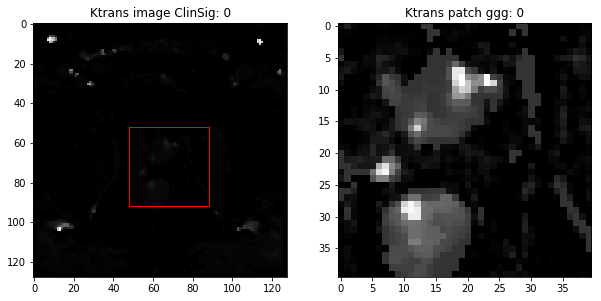

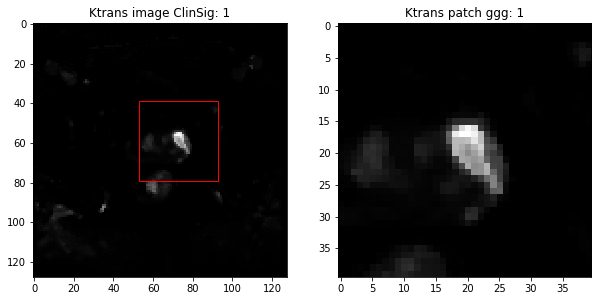

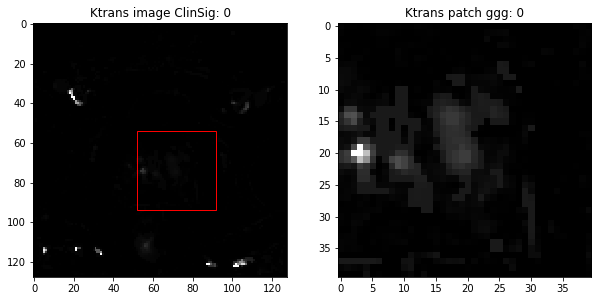

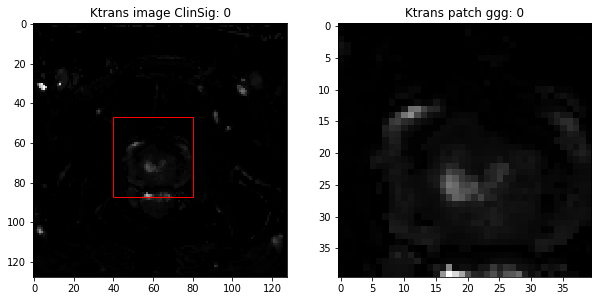

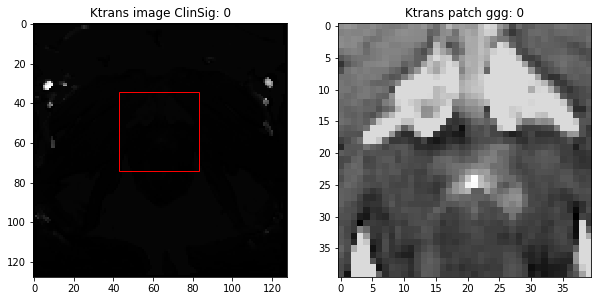

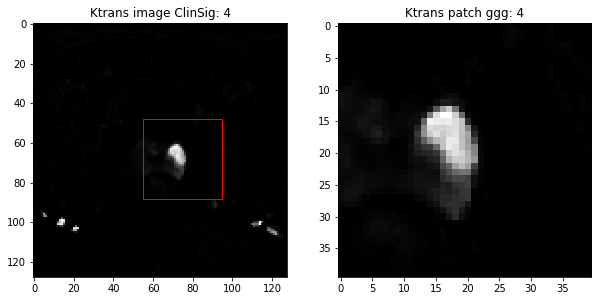

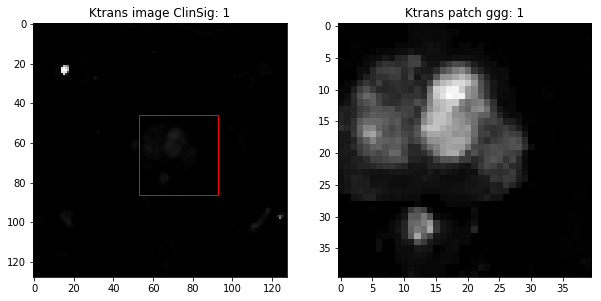

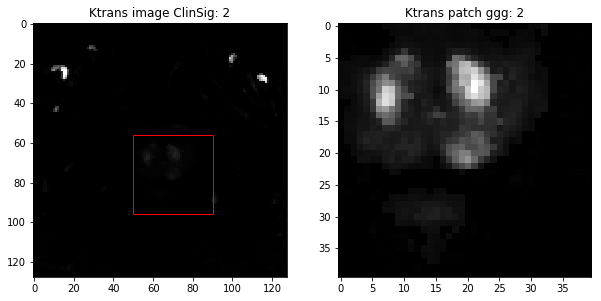

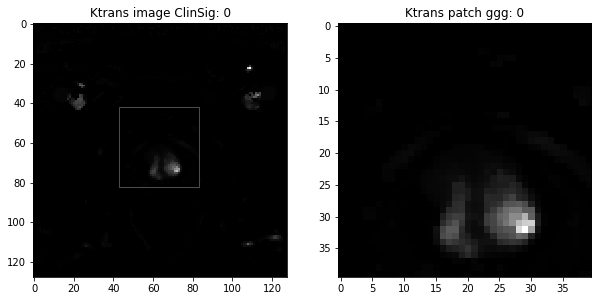

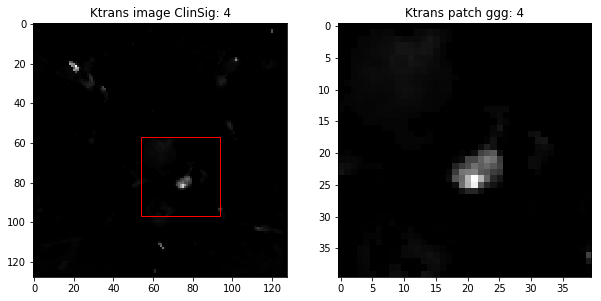

In [159]:
dataframe = training_ktrans_imgs_dataframe
number_of_plots = 10
indexes = np.random.randint(size= number_of_plots, low= 0 , high=len(dataframe))
for index in indexes:
    plot_ktrans_image_and_patch(dataframe, index)

In [160]:
len(training_ktrans_imgs_dataframe)

113